In [17]:
import pandas as pd 
import json
import os
import shutil

with open('annotations/train.json', 'r') as f:
  train = json.load(f)
train.keys()
with open('annotations/validate.json', 'r') as f:
  valid = json.load(f)
valid.keys()

dict_keys(['info', 'categories', 'images', 'annotations', 'licenses'])

In [26]:
os.makedirs('train',exist_ok=True)
os.makedirs('valid',exist_ok=True)

for images in valid['images']:
    fname = images['file_name']
    type_image = fname.split('_')[1]
    shutil.copy(f'{type_image}/{fname}',f'valid/{fname}')

In [41]:
len(train['images'])


94

In [42]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [43]:
dataDir='./'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

In [44]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [45]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['human']
Super-categories: {'None'}


Image n°15
Image name: .//train2017/cawin_human_image_413.png


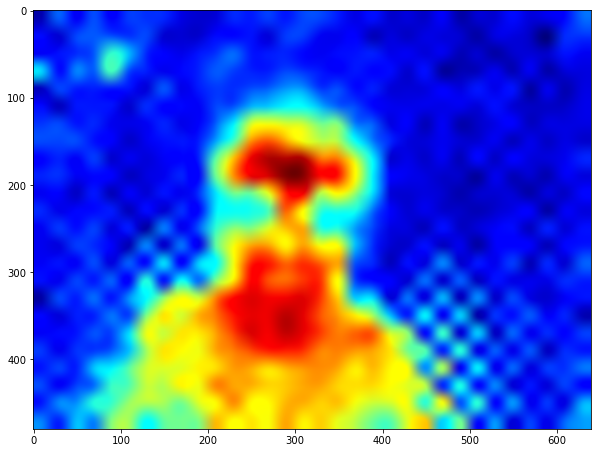

In [47]:
# load and display image
catIds = coco.getCatIds(catNms=['human'])
imgIds = coco.getImgIds(catIds=catIds )

img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

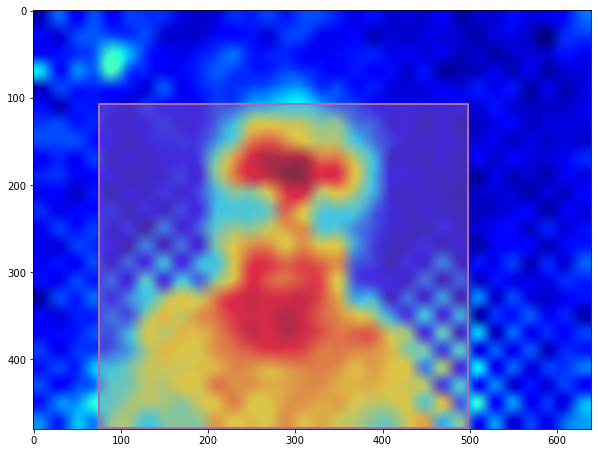

In [53]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

In [ ]:
os.makedirs('output',exist_ok=True)

## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [1]:
import torch

first_class_index = 0
num_classes = 1
finetuned_classes = ['human']

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet101',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('detr/outputs/checkpoint.pth',
                        map_location='cuda')

model.load_state_dict(checkpoint['model'],
                      strict=False)
model.to('cuda')

model.eval();

First class index: 0
Parameter num_classes: 1
Fine-tuned classes: ['human']


Using cache found in C:\Users\USER/.cache\torch\hub\facebookresearch_detr_main


In [60]:
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

c:\Users\USER\CodeProjects\SUTD\detr\sample_thermal\detr


Cloning into 'detr'...


Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.


Switched to a new branch 'finetune'


In [65]:
!python main.py \
  --dataset_file "." \
  --coco_path $dataDir \
  --output_dir "outputs" \
  --resume "detr-r101_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10

Not using distributed mode
git:
  sha: e42a3b174d2325c28f82d7114138c755ac7c095a, status: has uncommited changes, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='./', dataset_file='.', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=10, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=1, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r101_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
number of params: 41279238


Traceback (most recent call last):
  File "main.py", line 250, in <module>
    main(args)
  File "main.py", line 144, in main
    dataset_train = build_dataset(image_set='train', args=args)
  File "c:\Users\USER\CodeProjects\SUTD\detr\sample_thermal\detr\datasets\__init__.py", line 28, in build_dataset
    raise ValueError(f'dataset {args.dataset_file} not supported')
ValueError: dataset . not supported


In [70]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms as T


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
          
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to('cuda')
    return b

def plot_finetuned_results(pil_img, prob=None, boxes=None, save_dir=False, one_box=True):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if one_box:
      if prob is not None and boxes is not None:
        highest_prob_idx = torch.argmax(prob,axis=1)
        boxes = boxes[highest_prob_idx]
        prob = prob[highest_prob_idx]
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    else:
      if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    if save_dir:
      pil_img = pil_img.save(save_dir)
    plt.axis('off')
    plt.show()

def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], pil_image.size)
  
  return probas_to_keep, bboxes_scaled

def run_worflow(my_image, my_model, save_dir=False):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)
  img = img.to('cuda')
  # propagate through the model
  # DETR-RESNET101 takes 0.12s/120ms
  outputs = my_model(img)

  for threshold in [0.9, 0.7]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled,
                           save_dir=save_dir)
  return torch.max(probas_to_keep)

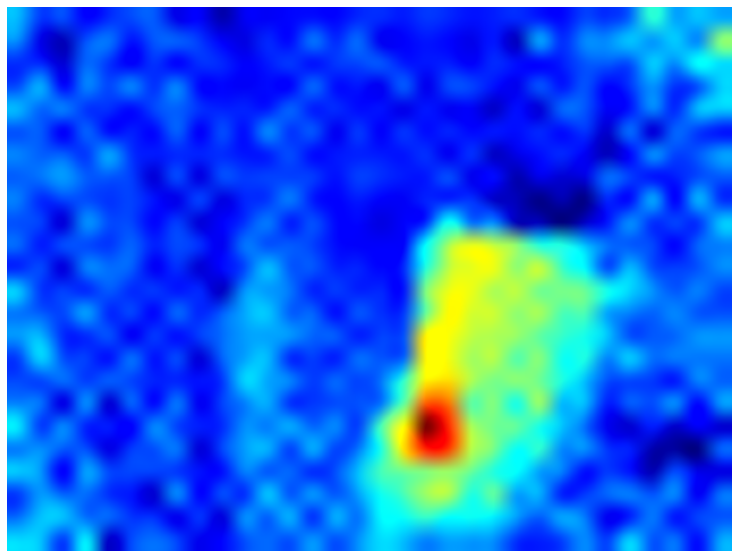

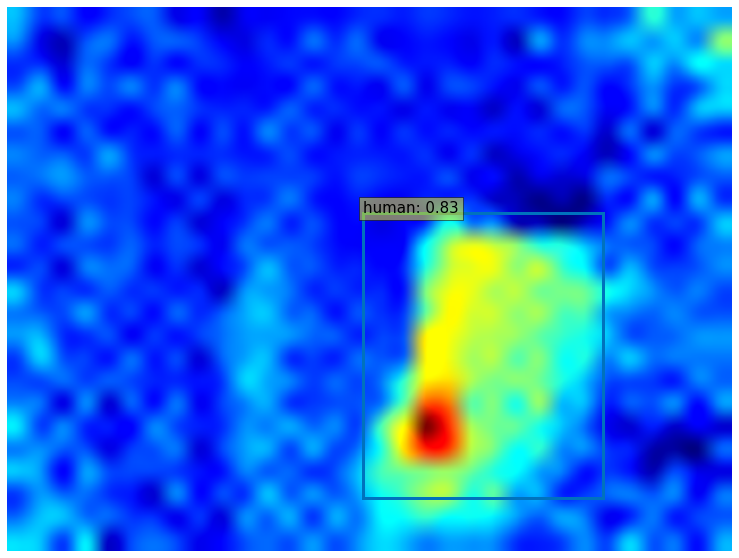

In [14]:
import time
import glob
from PIL import Image
import requests
import cv2
import numpy as np
from sample import SAMPLE



np.nan_to_num(0)

# If the difference between the hottest point and the coolest point is below a threshold value
# make the image blank as it is highly likely to be ambient data
# For testing purposes
# sample = td_to_img(sample,tmin,tmax)

# Image processing to resize for model
# Colour grayscale image
img = cv2.applyColorMap(cv2.bitwise_not(np.array(SAMPLE).astype(np.uint8)), cv2.COLORMAP_JET)
# Upscale Image
img = cv2.resize(img, (640,480), interpolation = cv2.INTER_CUBIC)
pil_image = Image.fromarray(img)
run_worflow(pil_image, model)

In [1]:
import glob
from PIL import Image

for fname in glob.glob('human/*.png'):
    img = Image.open(fname)
    file = fname.split('\\')[-1]
    print(file)
    # Image processing
    os.makedirs('output',exist_ok=True)
    run_worflow(img, model, save_dir=f'predicted\{file}')

cawin_human_image_100.png


NameError: name 'run_worflow' is not defined